In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.integrate import quad
from scipy.interpolate import interp1d, PchipInterpolator


In [2]:
beta_Gstar = 0.5 # kT
D0 = 0.01 # rescaled D/D0 so it won't be used

def beta_Gcnt(x):
    return 2*beta_Gstar*(-x+3.0/2*x**(2/3))

def Dcnt(x):
    # return D0*x**(2/3)
    return D0*x**0

x_arr = np.linspace(0, 3.5, 351)

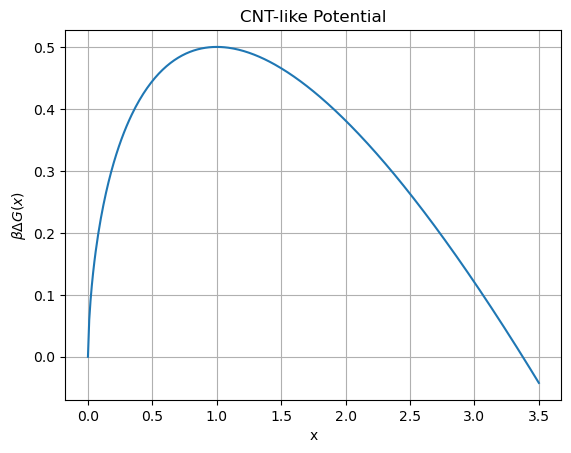

Text(0, 0.5, '$ D(x)$')

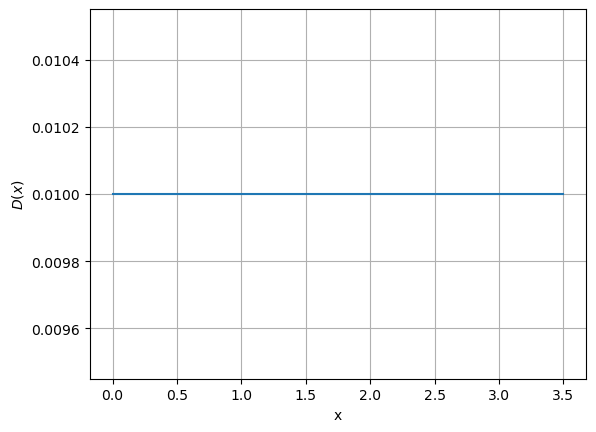

In [3]:
plt.plot(x_arr, beta_Gcnt(x_arr))
plt.grid()
plt.xlabel('x')
plt.ylabel("$ \\beta \\Delta G(x)$")
plt.title('CNT-like Potential')
plt.show()

plt.plot(x_arr, Dcnt(x_arr))
plt.grid()
plt.xlabel('x')
plt.ylabel("$ D(x)$")

### Numerical solve ODE with injecting boundary condition to find steady state solution

In [4]:
def kappa(x):
    return Dcnt(x)*np.exp(-beta_Gcnt(x))

N = x_arr.size
h = x_arr[1]-x_arr[0]

x_minus_half = x_arr[:]
x_plus_half = x_arr+h

b_arr = x_arr+h/2.0
u_arr = np.zeros(b_arr.size)

0.0009128274352682192


/tmp/ipykernel_791005/3470158452.py:11: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  u_arr[0:-1] = spsolve(A, f_vect)


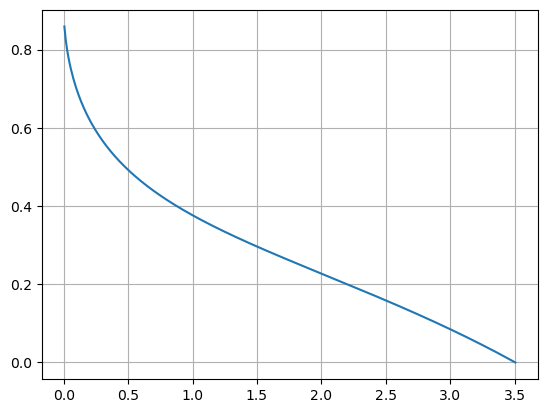

In [5]:
A = np.zeros((N-1, N-1))

np.fill_diagonal(A, -(kappa(x_minus_half)+kappa(x_plus_half)))
np.fill_diagonal(A[1:, ], kappa(x_minus_half[1:-1])) # subdiagonal
np.fill_diagonal(A[:, 1:], kappa(x_plus_half[:-2]))  # superdiagonal
A[0, 1] += kappa(x_minus_half[0])

f_vect = np.zeros(N-1)
f_vect[0] = 1

u_arr[0:-1] = spsolve(A, f_vect)
Pst_arr = u_arr*np.exp(-beta_Gcnt(b_arr))
Pst_arr /= (np.sum(Pst_arr)*h)

inject_rate = Dcnt(b_arr[-1])*np.exp(-beta_Gcnt(b_arr[-1])+beta_Gcnt(b_arr[-2]))*Pst_arr[-2]/(2.0*h)
print(inject_rate)

plt.plot(b_arr, Pst_arr)
plt.grid()

### Numerically Nest integrate for Steady-State Flux and Probability distribution function

In [6]:
a = 0   # location of reflecting boundary
b = 3.5  # location of absorbing boundary

# Define the inner function to integrate as a function of y
def inner_integrand(y):
    return 1.0/Dcnt(y)*np.exp(beta_Gcnt(y))

# Define the inner integral as a function of x
def inner_integral(x):
    y_lower = x
    y_upper = b
    result, error = quad(inner_integrand, y_lower, y_upper)
    return result

# Define the outer integral
x_lower = a
x_upper = b

# Define the outer function to integrate (also as a function of x)
def outer_integrand(x):
    return np.exp(-beta_Gcnt(x))*inner_integral(x)

# Perform the outer integration
invert_st_flux, error = quad(outer_integrand, x_lower, x_upper)
st_flux = 1.0/invert_st_flux
print(st_flux)

0.0018265698939117939


[0.85931521 0.82600042 0.80218511 0.78273046 0.76598278] [0.86037001 0.82701366 0.80316778 0.78368775 0.76691797]


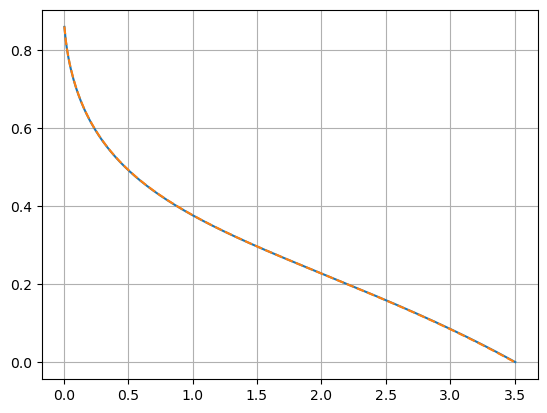

In [7]:
def st_P_func(x):
    def integrand(y):
        return 1.0/Dcnt(y)*np.exp(beta_Gcnt(y))
    # Perform the integration
    y_lower = x
    y_upper = b
    result, error = quad(integrand, y_lower, y_upper)
    result *= st_flux*np.exp(-beta_Gcnt(x))
        
    return result

st_P_arr = np.zeros(x_arr.size)
for i in np.arange(x_arr.size):
    st_P_arr[i] = st_P_func(b_arr[i])

plt.plot(b_arr, Pst_arr)
plt.plot(b_arr, st_P_arr, '--')

plt.grid()

print(Pst_arr[:5], st_P_arr[:5])

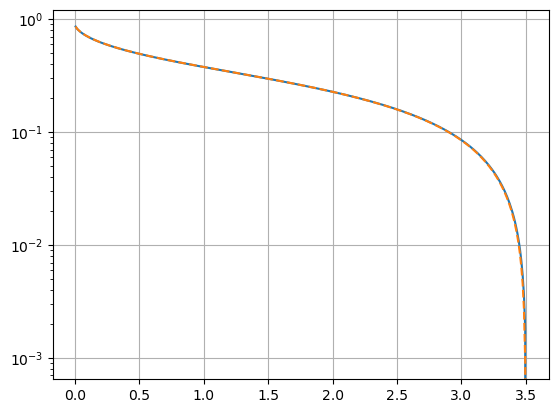

In [8]:
plt.semilogy(b_arr, Pst_arr)
plt.semilogy(b_arr, st_P_arr, '--')

plt.grid()

### Numerically Nest integrate for MFPT

In [9]:
# a = 0.0  # location of reflecting boundary
x0 = a   # Regura's method, overlap the starting point and reflecting boundary
# b = 3.5  # location of absorbing boundary

# Define the inner function to integrate as a function of z
def inner_integrand(z):
    return np.exp(-beta_Gcnt(z))

# Define the inner integral as a function of y
def inner_integral(y):
    z_lower = a
    z_upper = y
    result, error = quad(inner_integrand, z_lower, z_upper)
    return result

# Define the outer integral
y_lower = x0
y_upper = b

# Define the outer function to integrate (also as a function of y)
def outer_integrand(y):
    return np.exp(beta_Gcnt(y))*inner_integral(y)/Dcnt(y)

# Perform the outer integration (from x0 to b)
result, error = quad(outer_integrand, y_lower, y_upper)

114.17004811263163 = 2*t(x*)
548.7030413070606 = t(b)
547.4742594483442 = 1/J
547.7486550928252 = 1/inject_rate


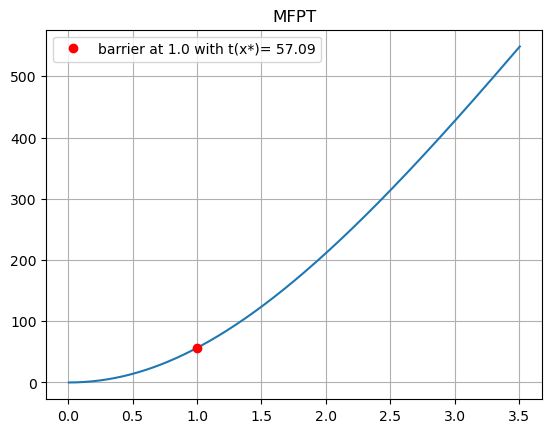

In [10]:
mfpt_arr = np.zeros(b_arr.size)
for i in np.arange(b_arr.size):
    mfpt_arr[i], _ = quad(outer_integrand, y_lower, b_arr[i])


idx_barrier = np.where((b_arr > 1.0) & (b_arr < 1.0 + h))
t_star = mfpt_arr[idx_barrier][0]
print(f"{2*t_star} = 2*t(x*)")
print(f"{mfpt_arr[-1]} = t(b)")
print(f"{invert_st_flux} = 1/J")
print(f"{1/inject_rate/2} = 1/inject_rate")

plt.plot(b_arr, mfpt_arr)
plt.plot(1.0, t_star , 'ro', label=f"barrier at 1.0 with t(x*)={t_star: .2f}")
plt.title('MFPT')
plt.legend()
plt.grid()

### Reconstruct Free Energy from Numerical Solution of Pst_arr and Numerical Integration of mfpt

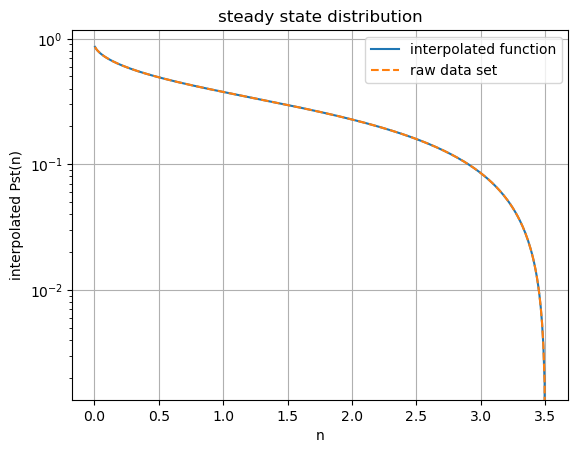

In [11]:
interp_Pst_func = interp1d(b_arr, Pst_arr, kind='cubic', fill_value="extrapolate")
# interp_Pst_func = PchipInterpolator(b_arr, Pst_arr)

plt.semilogy(b_arr, interp_Pst_func(b_arr), label="interpolated function")
plt.semilogy(b_arr, Pst_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated Pst(n)')
plt.title('steady state distribution')
plt.legend()
plt.grid()

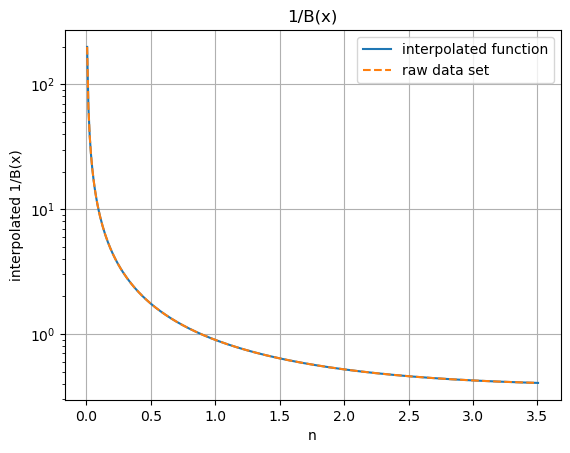

In [12]:
# Pst(b) = 0, and also avoid D(x)=0
integral_Pst_arr = np.zeros(b_arr.size-1)
Bx_arr = np.zeros(b_arr.size-1)

for i in range(b_arr.size-1):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, b_arr[i], b_arr[-1])
    Bx_arr[i] = -1.0/Pst_arr[i]*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[i])/(mfpt_arr[-1]))


interp_invertBx_func = interp1d(b_arr[:-1], 1.0/Bx_arr, kind='cubic', fill_value="extrapolate")

plt.semilogy(b_arr, interp_invertBx_func(b_arr), label="interpolated function")
plt.semilogy(b_arr[:-1], 1.0/Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

6.257376727191841e-08


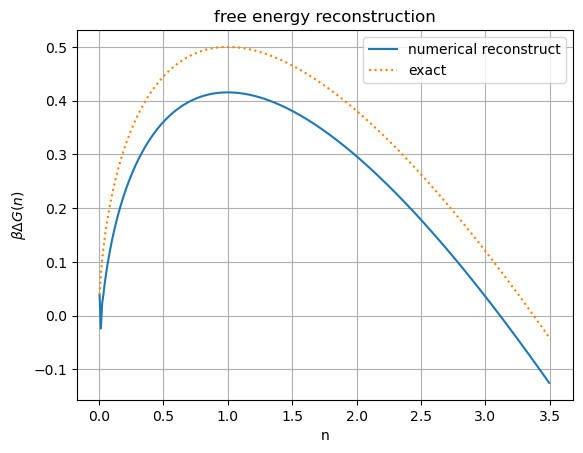

In [13]:
integral_invertBx_arr = np.zeros(b_arr.size-1)
beta_G_arr = np.zeros(b_arr.size-1)

for i in range(b_arr.size-1):
    # Here x0 is b_arr[0]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, b_arr[0], b_arr[i])
    beta_G_arr[i] = beta_Gcnt(b_arr[0])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(b_arr[:-1], beta_G_arr, label="numerical reconstruct")
plt.plot(b_arr, beta_Gcnt(b_arr), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

In [14]:
print(beta_G_arr[0], beta_Gcnt(b_arr[0]))
beta_G_arr[:20]

0.038860266073193005 0.038860266073193005


array([ 0.03886027, -0.02377976,  0.02284752,  0.03984922,  0.06055602,
        0.07734585,  0.09300614,  0.10725253,  0.12047416,  0.13279113,
        0.14433928,  0.15521222,  0.16548812,  0.17522982,  0.18448944,
        0.19331102,  0.20173184,  0.20978401,  0.21749538,  0.22489031])

### Reconstruct Free Energy from Numerical Integration of mfpt and Pst (st_P_func) - assume to be exact version

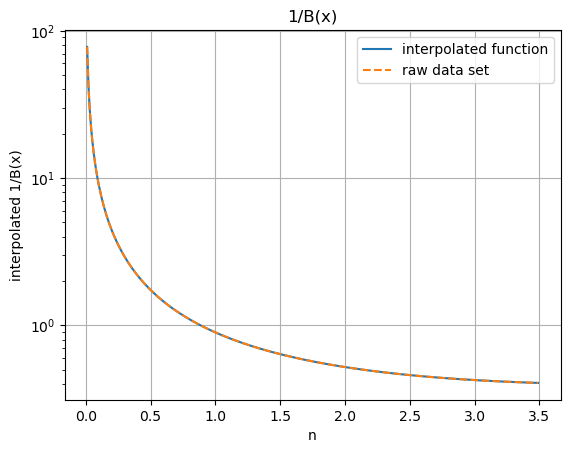

In [15]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(st_P_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/st_P_func(x_arr[1+i])*(integral_Pst_arr[i]-st_flux*(mfpt_arr[-1]-mfpt_arr[1+i]))

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(x_arr[1:-1], interp_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(x_arr[1:-1], 1.0/Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

7.100177560032287e-08


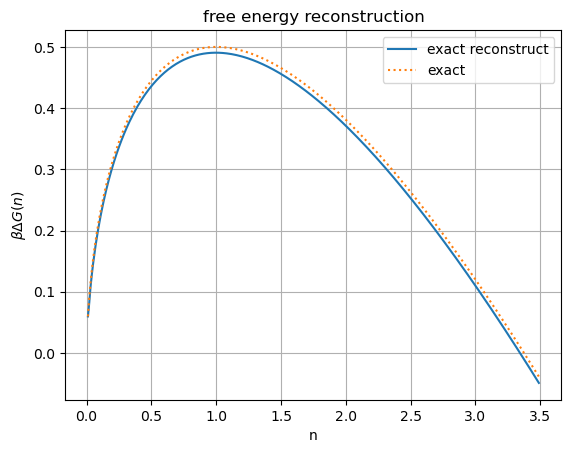

In [16]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="exact reconstruct")
plt.plot(x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

In [17]:
print(beta_Grec2_arr[0], beta_Gcnt(x_arr[1]))
beta_Grec2_arr[:20]

0.05962383250419168 0.05962383250419168


array([0.05962383, 0.0817721 , 0.10805044, 0.12796578, 0.14614587,
       0.16231796, 0.17712472, 0.19076554, 0.20344687, 0.21530436,
       0.22644732, 0.23696079, 0.24691382, 0.25636313, 0.26535608,
       0.27393279, 0.28212753, 0.28996994, 0.29748587, 0.30469798])

### Verify Hill Relation: plot the $1/flux,\ \tau(b),\  and\  2\tau(x*)$ v.s different location of absorbing boundary  

In [18]:
def exact_flux(a, b):
    # Define the inner function to integrate as a function of y
    def inner_integrand(y):
        return 1.0/Dcnt(y)*np.exp(beta_Gcnt(y))

    # Define the inner integral as a function of x
    def inner_integral(x):
        y_lower = x
        y_upper = b
        result, error = quad(inner_integrand, y_lower, y_upper)
        return result

    # Define the outer integral
    x_lower = a
    x_upper = b

    # Define the outer function to integrate (also as a function of x)
    def outer_integrand(x):
        return np.exp(-beta_Gcnt(x))*inner_integral(x)

    # Perform the outer integration
    invert_Jst, error = quad(outer_integrand, x_lower, x_upper)
    return 1/invert_Jst

In [19]:
# for valid value, exclude the refleting boundary
Jst_arr = np.zeros(N-1)

for i in np.arange(N-1):
    Jst_arr[i] = exact_flux(x_arr[0], x_arr[1+i])

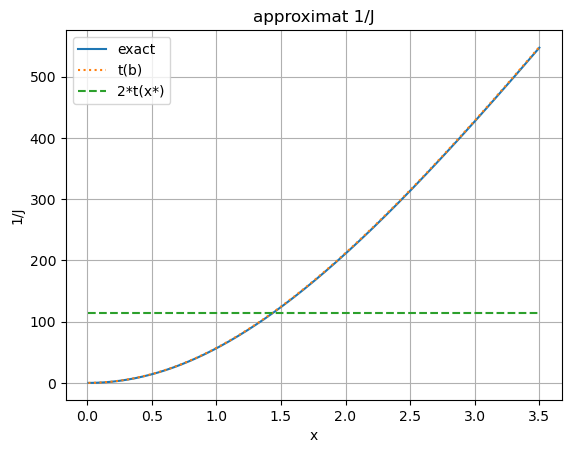

In [20]:
plt.plot(x_arr[1:], 1/Jst_arr, label="exact")
plt.plot(x_arr[1:], mfpt_arr[1:], ':', label="t(b)")
plt.plot(x_arr[1:], 2*t_star*np.ones(x_arr[1:].size), '--', label="2*t(x*)")

# Plot formatting
plt.xlabel('x')
plt.ylabel('1/J')
plt.title('approximat 1/J')
plt.legend()
plt.grid()

### Transfer Matrix with Recycling Boundary Condition

In [21]:
from transfer_matrix_reptile import TransferMatrix_ReInAb

ria_trans = TransferMatrix_ReInAb(hx=h, x_arr=x_arr, beta_U=beta_Gcnt, criteria=0)

(450359962737049.1-0j)


/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/yjiang23/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


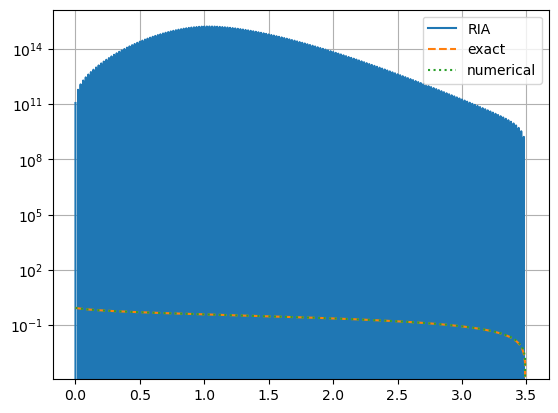

In [22]:
# plt.plot(x_arr[:-1], ria_trans.steady_state, label="RIA")
# # plt.plot(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA") # use when first LM eigenvalue is not 1
# plt.plot(x_arr, st_P_arr, '--', label="exact")
# plt.plot(b_arr, Pst_arr, ':', label="numerical")

plt.semilogy(x_arr[:-1], ria_trans.steady_state, label="RIA")
# plt.semilogy(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA") # use when first LM eigenvalue is not 1
plt.semilogy(x_arr, st_P_arr, '--', label="exact")
plt.semilogy(x_arr, Pst_arr, ':', label="numerical")

plt.legend()
plt.grid()

print(ria_trans.relax_timescale)

/home/yjiang23/Desktop/research/MFPT/MFPT_reconst_experiment/transfer_matrix_reptile.py:547: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigenvalues, eigenvectors_mat = eigs(self.trans_mat, k=num_eigenvalues)


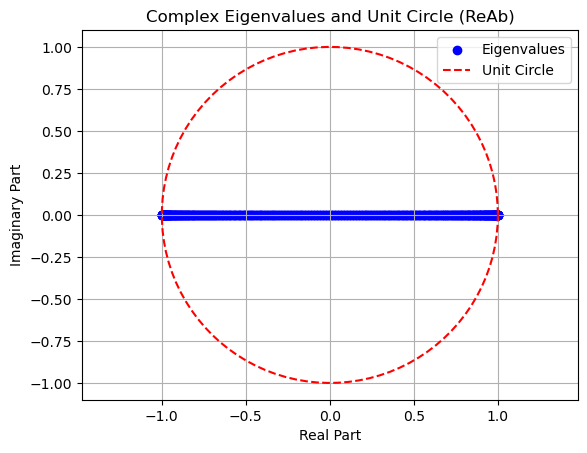

[-0.99917219+0.00000000e+00j  1.        +0.00000000e+00j
  0.99984279+2.80318335e-05j  0.99984279-2.80318335e-05j
  0.99936447+4.63810175e-05j  0.99936447-4.63810175e-05j]


In [23]:
ria_trans.plot_eigenvalues()
print(ria_trans.eig6_w)

[0.89149462+0.j 0.83807773+0.j 0.81076332+0.j 0.78948111+0.j
 0.77155434+0.j 0.75586817+0.j 0.74182266+0.j 0.72904839+0.j
 0.71729766+0.j 0.70639436+0.j]


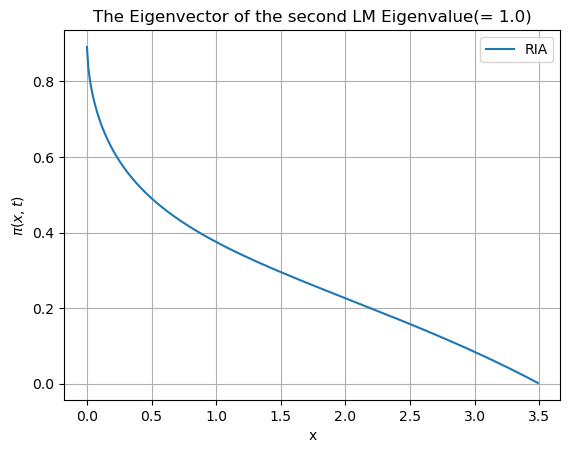

In [24]:
plt.plot(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA")
# Plot formatting
plt.xlabel('x')
plt.ylabel('$ \pi(x,t) $')
plt.title(f'The Eigenvector of the second LM Eigenvalue(= {ria_trans.eig6_w[1].real.round(6)})')
plt.legend()
plt.grid(True)
print(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1][:10])

### Extract Steady State Distribution and MFPT from Simulation

In [25]:
from mfpt_Pst_RW_simulate import simulate_ReAb, simulate_ReAb_accelerate

num_particles = 600
init_position_arr = np.zeros(num_particles, dtype=float)
simu_x_arr = np.linspace(a, b, 351)
hx = simu_x_arr[1]-simu_x_arr[0]
ht = hx**2/(2*D0)
n_arr = np.arange(a, b+0.01, 0.01)
n_arr = np.round(n_arr, decimals=5)
hx == 0.01

True

In [26]:
count_n, ti_n = simulate_ReAb_accelerate(init_position_arr=init_position_arr, beta_U=beta_Gcnt, n_arr=n_arr, a=a, b=b, hx=hx, ht=ht)

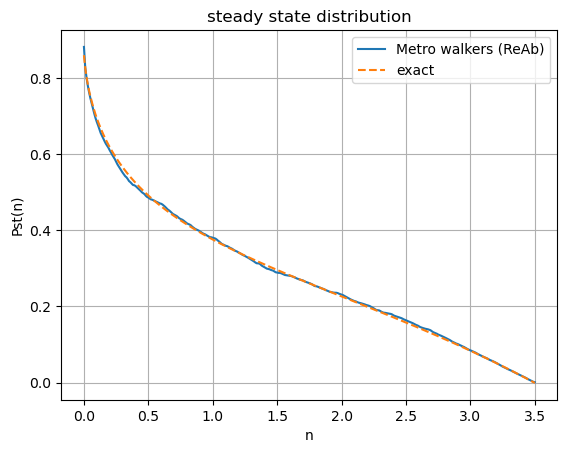

In [27]:
Pst_n = count_n/(hx*np.sum(count_n))
plt.plot(n_arr, Pst_n, label="Metro walkers (ReAb)")
plt.plot(x_arr, st_P_arr, '--', label="exact")
# plt.plot(x_arr[:-1], ria_trans.steady_state, label="RIA")
# plt.plot(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA") # use when first LM eigenvalue is not 1

# Plot formatting
plt.xlabel('n')
plt.ylabel('Pst(n)')
plt.title('steady state distribution')
plt.legend()
plt.grid()

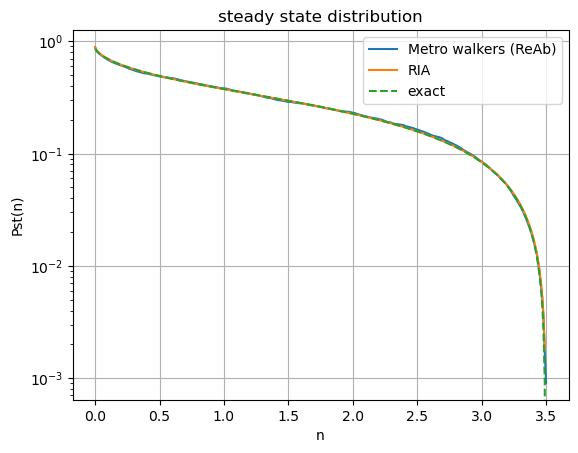

In [28]:
plt.semilogy(n_arr, Pst_n, label="Metro walkers (ReAb)")
# plt.semilogy(x_arr[:-1], ria_trans.steady_state, ':', label="RIA")
plt.semilogy(x_arr[:-1], 1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], label="RIA") # use when first LM eigenvalue is not 1
plt.semilogy(x_arr, st_P_arr, '--', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('Pst(n)')
plt.title('steady state distribution')
plt.legend()
plt.grid()

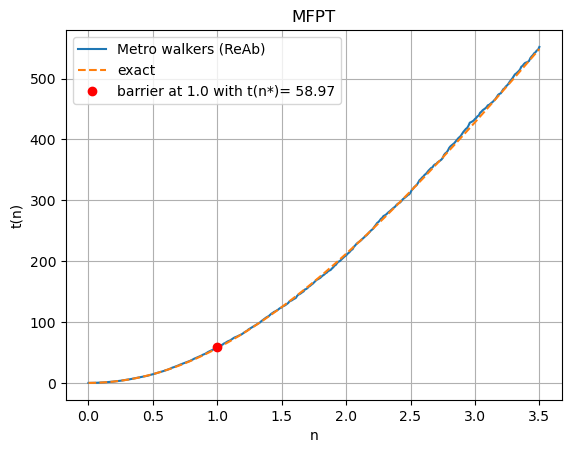

In [29]:
mfpt_simu_arr = np.mean(ti_n, axis=0)
idx_barrier = np.where(n_arr == 1.0)[0][0]
t_star = mfpt_simu_arr[idx_barrier]

plt.plot(n_arr, mfpt_simu_arr, label="Metro walkers (ReAb)")
plt.plot(x_arr, mfpt_arr, '--', label="exact")
plt.plot(1.0, t_star , 'ro', label=f'barrier at 1.0 with t(n*)={t_star: .2f}')
# Plot formatting
plt.xlabel('n')
plt.ylabel('t(n)')
plt.title('MFPT')
plt.legend()
plt.grid()

### Reconstruct Free Energy Using mfpt (mfpt_simu_arr) and Pst (Pst_n) extracted from Simulation

#### (1) Exact Steady State Distribution with simulated MFPT

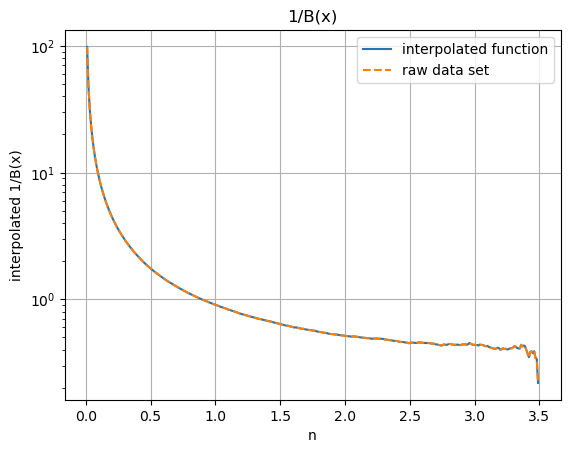

In [30]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(st_P_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/st_P_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(x_arr[1:-1], interp_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(x_arr[1:-1], 1.0/Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/2563123347.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])


0.001538636968186311


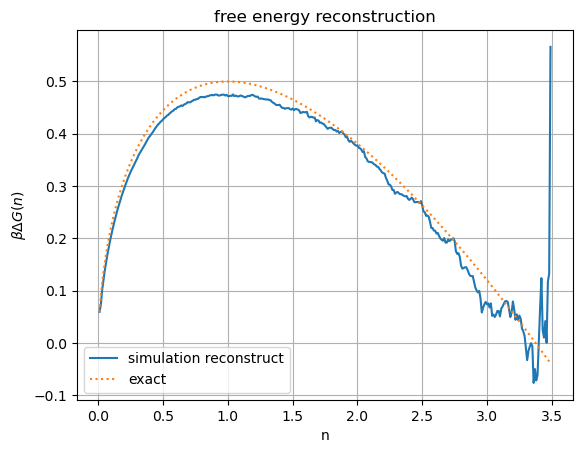

In [31]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="simulation reconstruct")
plt.plot(x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (2) Transfer Matrix Steady State Distribution with exact MFPT and then with simulated MFPT

/tmp/ipykernel_791005/2819856665.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  interp_Pst_func = interp1d(x_arr[:-1], np.array(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], dtype=float), kind='cubic', fill_value="extrapolate") # use when first LM eigenvalue is not 1
/tmp/ipykernel_791005/2819856665.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.semilogy(x_arr[:-1], np.array(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], dtype=float), '--', label="raw data set") # use when first LM eigenvalue is not 1


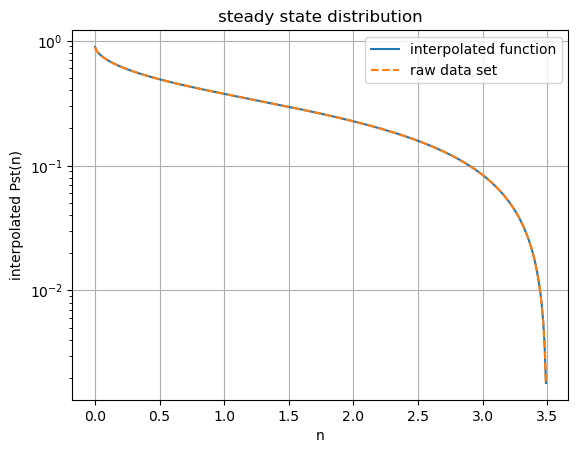

In [32]:
# interp_Pst_func = interp1d(x_arr[:-1], np.array(ria_trans.steady_state, dtype=float), kind='cubic', fill_value="extrapolate")
interp_Pst_func = interp1d(x_arr[:-1], np.array(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], dtype=float), kind='cubic', fill_value="extrapolate") # use when first LM eigenvalue is not 1

plt.semilogy(x_arr[:-1], interp_Pst_func(x_arr[:-1]), label="interpolated function")
# plt.semilogy(x_arr[:-1], ria_trans.steady_state, '--', label="raw data set")
plt.semilogy(x_arr[:-1], np.array(1.0/(h*np.sum(ria_trans.eig6_v[:, 1]))*ria_trans.eig6_v[:, 1], dtype=float), '--', label="raw data set") # use when first LM eigenvalue is not 1

# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated Pst(n)')
plt.title('steady state distribution')
plt.legend()
plt.grid()

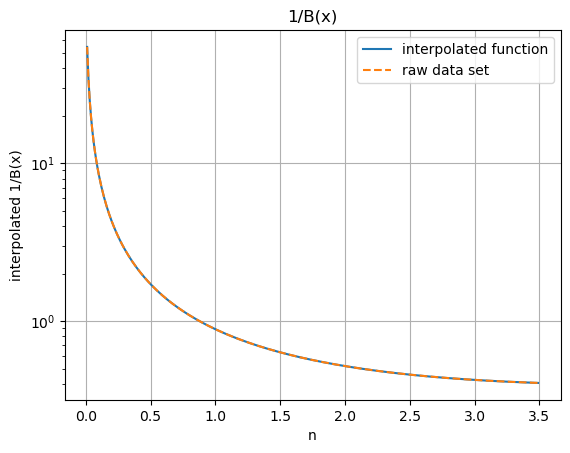

In [33]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
    # Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])
    Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-st_flux*(mfpt_arr[-1]-mfpt_arr[1+i])) # use when first LM eigenvalue is not 1

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(x_arr[1:-1], interp_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(x_arr[1:-1], 1.0/Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

2.300882127407607e-08


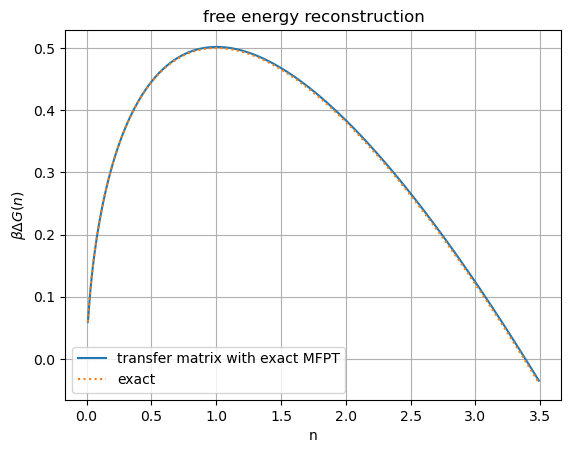

In [34]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="transfer matrix with exact MFPT")
plt.plot(x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

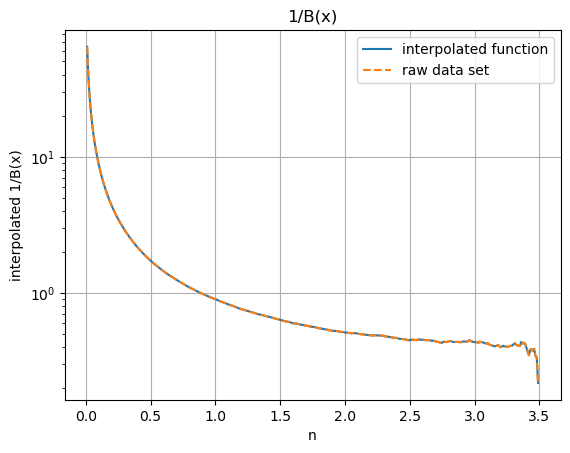

In [35]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_Pst_func, x_arr[1+i], x_arr[-1])
    Bx_arr[i] = -1.0/interp_Pst_func(x_arr[1+i])*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_invertBx_func = interp1d(x_arr[1:-1], 1.0/Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(x_arr[1:-1], interp_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(x_arr[1:-1], 1.0/Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/2741261074.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])


0.0002743371093121283


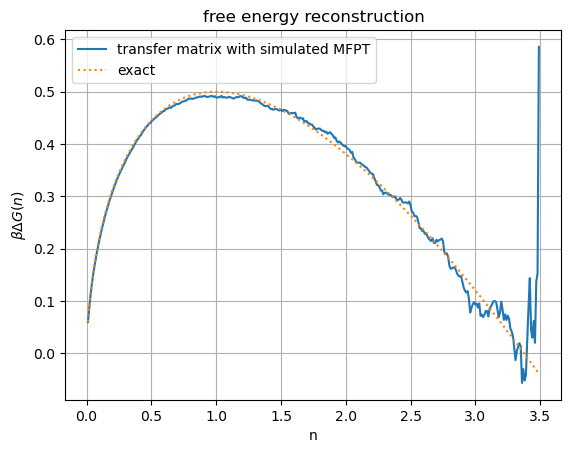

In [36]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_invertBx_func, x_arr[1], x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(x_arr[1])+np.log(Bx_arr[i]/Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(x_arr[1:-1], beta_Grec2_arr, label="transfer matrix with simulated MFPT")
plt.plot(x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

#### (3) Simulated Steady State Distribution with exact MFPT and then with simulated MFPT

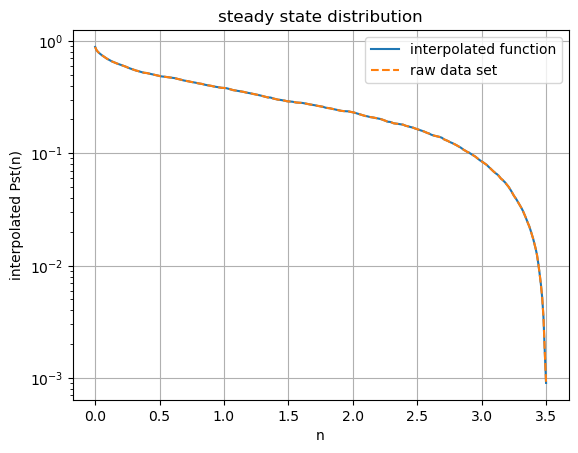

In [37]:
interp_simu_Pst_func = interp1d(simu_x_arr, Pst_n, kind='cubic', fill_value="extrapolate")
# interp_Pst_func = PchipInterpolator(b_arr, Pst_arr)

plt.semilogy(simu_x_arr, interp_simu_Pst_func(simu_x_arr), label="interpolated function")
plt.semilogy(simu_x_arr, Pst_n, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated Pst(n)')
plt.title('steady state distribution')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/3951444635.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, simu_x_arr[1+i], simu_x_arr[-1])


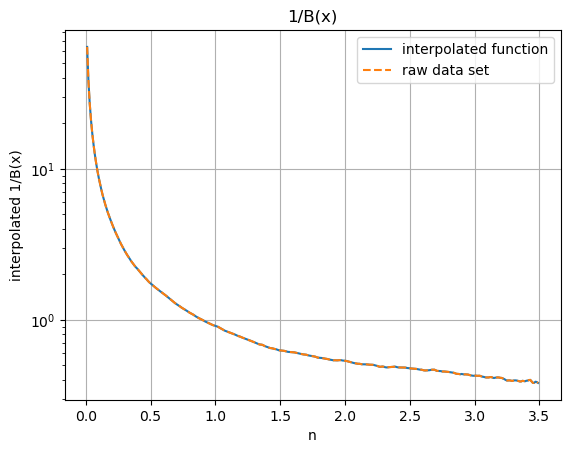

In [38]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
simu_Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, simu_x_arr[1+i], simu_x_arr[-1])
    simu_Bx_arr[i] = -1.0/Pst_n[1+i]*(integral_Pst_arr[i]-(mfpt_arr[-1]-mfpt_arr[1+i])/mfpt_arr[-1])

interp_simu_invertBx_func = interp1d(x_arr[1:-1], 1.0/simu_Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(simu_x_arr[1:-1], interp_simu_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(simu_x_arr[1:-1], 1.0/simu_Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/4156853672.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, simu_x_arr[1], simu_x_arr[1+i])


0.0016883024552473765


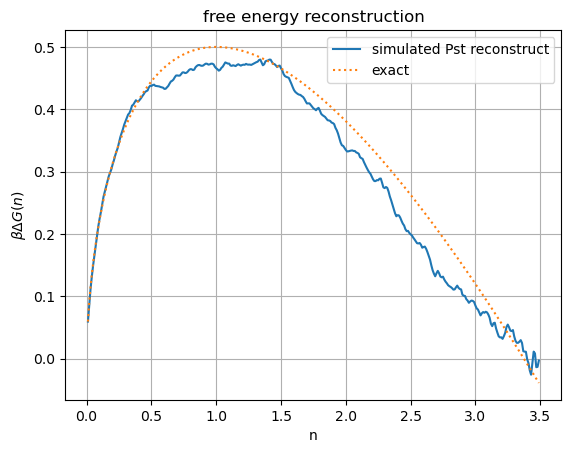

In [39]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, simu_x_arr[1], simu_x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(simu_x_arr[1])+np.log(simu_Bx_arr[i]/simu_Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(simu_x_arr[1:-1], beta_Grec2_arr, label="simulated Pst reconstruct")
plt.plot(simu_x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/1053423012.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, simu_x_arr[1+i], simu_x_arr[-1])


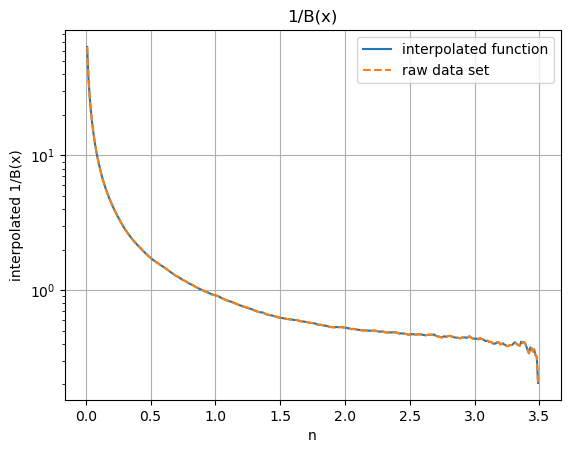

In [40]:
# Except for the absorbing boundary Pst(b) = 0, D(x)=0, also avoid at reflecting boundary A(x)=0, B(x)=0, 
simu_Bx_arr = np.zeros(N-2)
integral_Pst_arr = np.zeros(N-2)
for i in range(N-2):
    integral_Pst_arr[i], _ = quad(interp_simu_Pst_func, simu_x_arr[1+i], simu_x_arr[-1])
    simu_Bx_arr[i] = -1.0/Pst_n[1+i]*(integral_Pst_arr[i]-(mfpt_simu_arr[-1]-mfpt_simu_arr[1+i])/mfpt_simu_arr[-1])

interp_simu_invertBx_func = interp1d(simu_x_arr[1:-1], 1.0/simu_Bx_arr, kind='cubic') # fill_value="extrapolate")

plt.semilogy(simu_x_arr[1:-1], interp_simu_invertBx_func(x_arr[1:-1]), label="interpolated function")
plt.semilogy(simu_x_arr[1:-1], 1.0/simu_Bx_arr, '--', label="raw data set")
# Plot formatting
plt.xlabel('n')
plt.ylabel('interpolated 1/B(x)')
plt.title('1/B(x)')
plt.legend()
plt.grid()

/tmp/ipykernel_791005/1290495388.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, simu_x_arr[1], simu_x_arr[1+i])


0.0025593030964235356


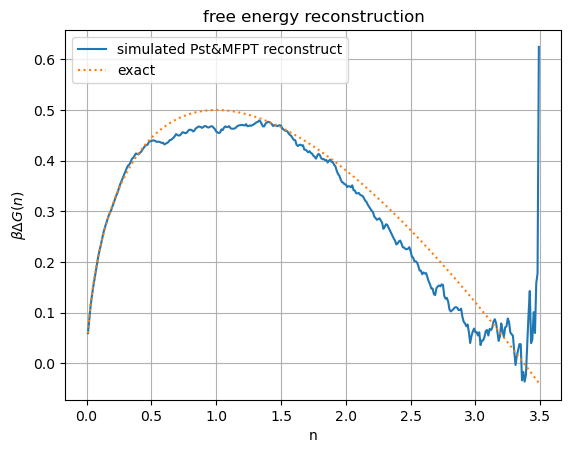

In [41]:
integral_invertBx_arr = np.zeros(N-2)
beta_Grec2_arr = np.zeros(N-2)

for i in range(N-2):
    # Here x0 is x_arr[1]
    integral_invertBx_arr[i], _ = quad(interp_simu_invertBx_func, simu_x_arr[1], simu_x_arr[1+i])
    beta_Grec2_arr[i] = beta_Gcnt(simu_x_arr[1])+np.log(simu_Bx_arr[i]/simu_Bx_arr[0])-integral_invertBx_arr[i]

print(_)

plt.plot(simu_x_arr[1:-1], beta_Grec2_arr, label="simulated Pst&MFPT reconstruct")
plt.plot(simu_x_arr[1:-1], beta_Gcnt(x_arr[1:-1]), ':', label="exact")

# Plot formatting
plt.xlabel('n')
plt.ylabel('$ \\beta \Delta G(n) $')
plt.title('free energy reconstruction')
plt.legend()
plt.grid()